
# Identifying Sleep Times

## Notebook Goal: 
* Create visualization pipelines for each patient to identify sleep times.
* Create a function to identify sleep times for each patient.


In [1]:
%load_ext autoreload
%autoreload 2

## Data Load

In [19]:
from src.data.data_loader import load_data
from src.data.data_cleaner import clean_data
import pandas as pd

# Load the data with specified columns
df = load_data(data_source_name="kaggle_brisT1D", dataset_type="train")

In [3]:
def keep_time_zero_columns(
    df, additional_cols: list = ["id", "p_num", "time", "bg+1:00"]
):
    """
    Provide a list of columns to keep that contain '-0:00' in their names

    Args:
        df (pd.DataFrame): Input DataFrame
        additional_cols (list): List of columns to keep in addition to the ones with '-0:00' in their names

    Returns:
        list: list of column names
    """
    time_zero_cols = [col for col in df.columns if "-0:00" in col]
    additional_cols += time_zero_cols
    print(f"Keeping {additional_cols} columns")
    return additional_cols


keep_columns_train = keep_time_zero_columns(df)
keep_columns_test = keep_columns_train.copy()
keep_columns_test.remove("bg+1:00")
print("train columns: ", keep_columns_train)
print("test columns: ", keep_columns_test)

Keeping ['id', 'p_num', 'time', 'bg+1:00', 'bg-0:00', 'insulin-0:00', 'carbs-0:00', 'hr-0:00', 'steps-0:00', 'cals-0:00', 'activity-0:00'] columns
train columns:  ['id', 'p_num', 'time', 'bg+1:00', 'bg-0:00', 'insulin-0:00', 'carbs-0:00', 'hr-0:00', 'steps-0:00', 'cals-0:00', 'activity-0:00']
test columns:  ['id', 'p_num', 'time', 'bg-0:00', 'insulin-0:00', 'carbs-0:00', 'hr-0:00', 'steps-0:00', 'cals-0:00', 'activity-0:00']


In [4]:
train_df = load_data(
    data_source_name="kaggle_brisT1D",
    dataset_type="train",
    keep_columns=keep_columns_train,
)

In [12]:
sample_df = train_df[train_df["p_num"] == "p01"]
sample_df.shape


(8459, 11)

In [23]:
# sample_df = clean_data(sample_df)
sample_df.dtypes




id                       object
p_num                    object
time             datetime64[ns]
bg-0:00                 float64
insulin-0:00            float64
carbs-0:00              float64
hr-0:00                 float64
steps-0:00              float64
cals-0:00               float64
activity-0:00            object
hour                      int32
dtype: object

C:\Users\viloh\AppData\Local\Temp\ipykernel_26320\2560405690.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['time'] = pd.to_datetime(sample_df['time'])
C:\Users\viloh\AppData\Local\Temp\ipykernel_26320\2560405690.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['hour'] = sample_df['time'].dt.hour


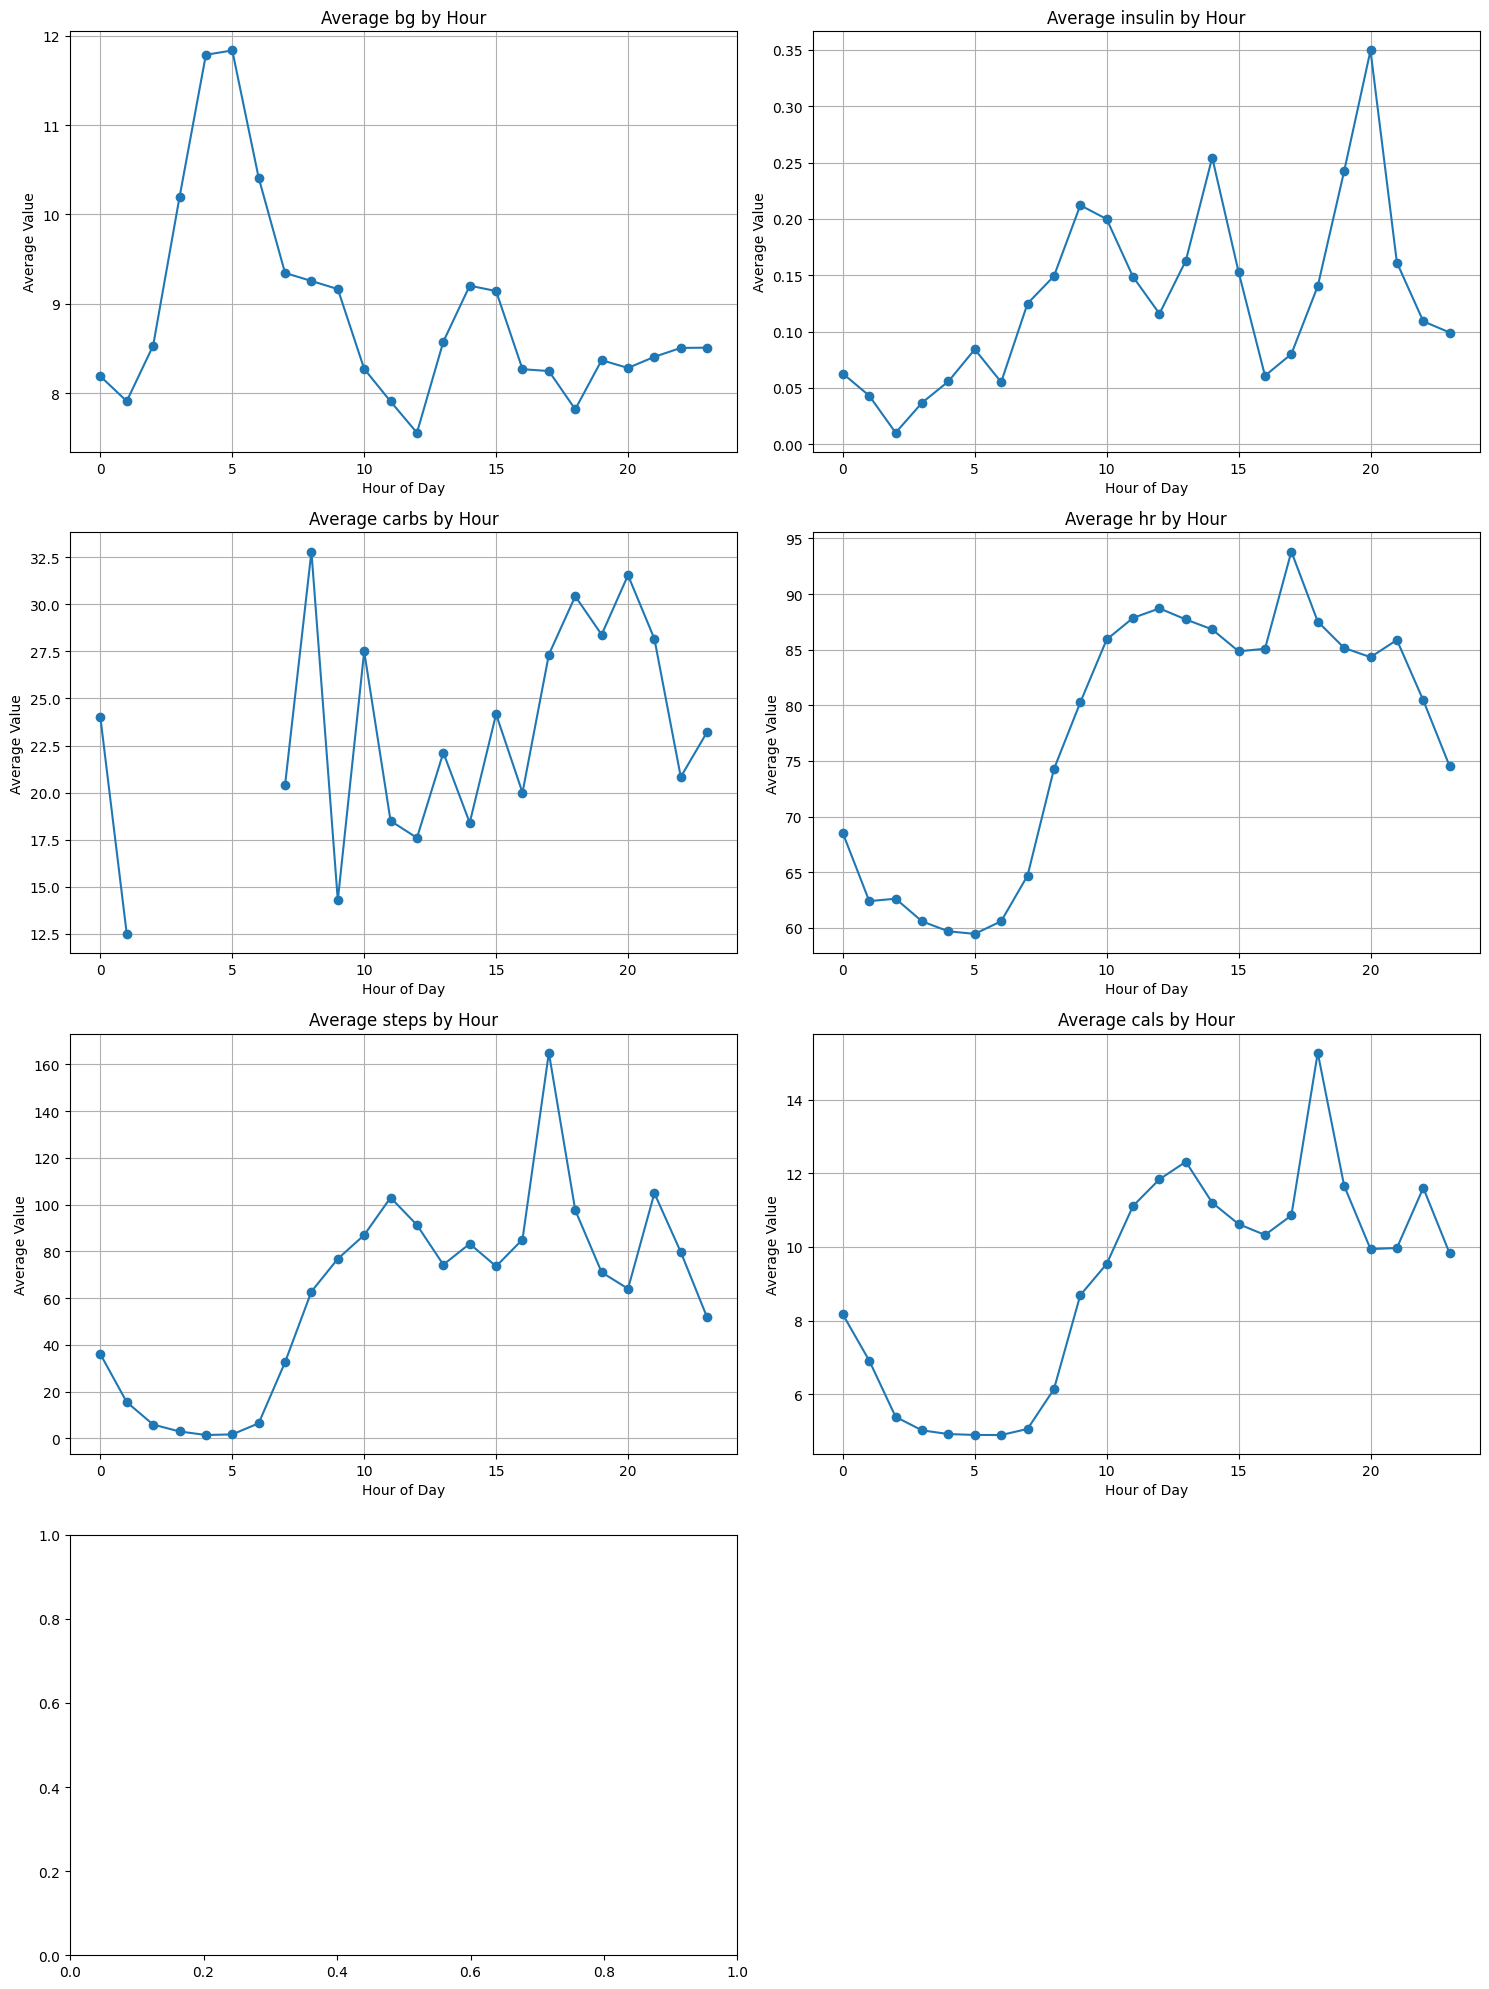

In [24]:
import matplotlib.pyplot as plt
# Convert time to datetime for proper plotting
sample_df['time'] = pd.to_datetime(sample_df['time'])
sample_df['hour'] = sample_df['time'].dt.hour

# Calculate means by hour for each measurement type, ignoring NaN values
feature_cols = ['bg-0:00', 'insulin-0:00', 'carbs-0:00', 'hr-0:00', 'steps-0:00', 'cals-0:00']
hourly_means = sample_df.groupby('hour')[feature_cols].agg(lambda x: x.mean(skipna=True))

# Create subplots for each feature
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()

# Plot each feature
for idx, col in enumerate(feature_cols):
    ax = axes[idx]
    # Only plot if there are non-NaN values
    if hourly_means[col].notna().any():
        hourly_means[col].plot(kind='line', marker='o', ax=ax)
        ax.set_title(f'Average {col.split("-")[0]} by Hour')
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel('Average Value')
        ax.grid(True)
    else:
        ax.text(0.5, 0.5, 'No data available', 
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax.transAxes)
        ax.set_title(f'{col.split("-")[0]} - No Data')

# Remove the last empty subplot
axes[-1].remove()

# Adjust layout
plt.tight_layout()
plt.show()


In [7]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)